**Exploratory Data Analysis of CHAMPS dataset**
# PART 1: INTRO and look at the types of couplings

In [11]:
# module imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ggplot style visuals
plt.style.use('ggplot')

# set input directory
in_dir = '../input/'

## What is coupling constant and why should I care?

**NMR** (Nuclear Magnetic Resonance) is technique used in medical imaging, chemistry etc to learn about structure of materials. Certain atoms (notably C-13 and H-1) have intrinsic magnetic dipole (ie tiny magnet). When subjected to external magnetic field these magnets align (which also aligns their bonding electron).

However atoms that are next to each other do not like when their shared electrons try to have same spin (Pauli exclusion principle). So, they create a split where atom 1 spin is up and atom 2 spin is down, and vice versa. This is **1J** coupling. Atom 1 affecting spind  of its neighbour atom 2 will also affect atom 3 which is neighbor of atom 2 (**2J**) and so on and so forth. It is the strength of these couplings that needs to be determined (which is usually calculated by simulations for days). 

References:
- https://en.wikipedia.org/wiki/Nuclear_magnetic_resonance
- https://www.chem.wisc.edu/areas/reich/nmr/Notes-05-HMR-v26-part2.pdf

![NMR spectra of two H atoms coupling](https://acdlabs.typepad.com/photos/uncategorized/2008/04/07/metacoupling_apr72008.gif "J-coupling between two H atoms in benzene and its'fingerprint'")

*imagee source:* https://acdlabs.typepad.com/elucidation/2008/04/identifying-met.html

## Data files provided

Let us get familiar with given files. Description from Kaggle

---
* In this competition, you will be predicting the scalar_coupling_constant between atom pairs in molecules, given the two atom types (e.g., C and H), the coupling type (e.g., 2JHC), and any features you are able to create from the molecule structure (xyz) files.
* For this competition, you will not be predicting all the atom pairs in each molecule rather, you will only need to predict the pairs that are explicitly listed in the train and test files. For example, some molecules contain Fluorine (F), but you will not be predicting the scalar coupling constant for any pair that includes F.
* The training and test splits are by molecule, so that no molecule in the training data is found in the test data.

**Files**
* train.csv - the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (scalar_coupling_constant) is the scalar coupling constant that we want to be able to predict

* test.csv - the test set; same info as train, without the target variable
* sample_submission.csv - a sample submission file in the correct format
* structures.zip - folder containing molecular structure (xyz) files, where the first line is the number of atoms in the molecule, followed by a blank line, and then a line for every atom, where the first column contains the atomic element (H for hydrogen, C for carbon etc.) and the remaining columns contain the X, Y and Z cartesian coordinates (a standard format for chemists and molecular visualization programs)
structures.csv - this file contains the same information as the individual xyz structure files, but in a single file

**Additional Data**

NOTE: additional data is provided for the molecules in Train only!
* dipole_moments.csv - contains the molecular electric dipole moments. These are three dimensional vectors that indicate the charge distribution in the molecule. The first column (molecule_name) are the names of the molecule, the second to fourth column are the X, Y and Z components respectively of the dipole moment.

* magnetic_shielding_tensors.csv - contains the magnetic shielding tensors for all atoms in the molecules. The first column (molecule_name) contains the molecule name, the second column (atom_index) contains the index of the atom in the molecule, the third to eleventh columns contain the XX, YX, ZX, XY, YY, ZY, XZ, YZ and ZZ elements of the tensor/matrix respectively.

* mulliken_charges.csv - contains the mulliken charges for all atoms in the molecules. The first column (molecule_name) contains the name of the molecule, the second column (atom_index) contains the index of the atom in the molecule, the third column (mulliken_charge) contains the mulliken charge of the atom.

* potential_energy.csv - contains the potential energy of the molecules. The first column (molecule_name) contains the name of the molecule, the second column (potential_energy) contains the potential energy of the molecule.

* scalar_coupling_contributions.csv - The scalar coupling constants in train.csv (or corresponding files) are a sum of four terms. scalar_coupling_contributions.csv contain all these terms. The first column (molecule_name) are the name of the molecule, the second (atom_index_0) and third column (atom_index_1) are the atom indices of the atom-pair, the fourth column indicates the type of coupling, the fifth column (fc) is the Fermi Contact contribution, the sixth column (sd) is the Spin-dipolar contribution, the seventh column (pso) is the Paramagnetic spin-orbit contribution and the eighth column (dso) is the Diamagnetic spin-orbit contribution.
---



**train.csv** and **test.csv**

In [12]:
pd.read_csv(in_dir+'train.csv', nrows=10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.2543
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095


In [13]:
# what is type?
pdtrain = pd.read_csv(in_dir+'train.csv')
# we will need this one later
TYPES = list(pdtrain["type"].unique())
print(TYPES)
del pdtrain

['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']


1JHC means, coupling between H and C through one bond (H-C). Why there is no 1JHH, worth thinking about? :)

In [14]:
# is test.csv different?
pd.read_csv(in_dir+'test.csv', nrows=10)

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC
5,4658152,dsgdb9nsd_000015,3,0,1JHC
6,4658153,dsgdb9nsd_000015,3,2,3JHC
7,4658154,dsgdb9nsd_000015,3,4,2JHH
8,4658155,dsgdb9nsd_000015,3,5,2JHH
9,4658156,dsgdb9nsd_000015,4,0,1JHC


Seems like **structures.csv** is just a convenience file, so that we do not fiddle with structures folder unless we really want to. Let us check

In [15]:
pd.read_csv(in_dir+'structures.csv', nrows=10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


Seems so. What about **additinoal data**? Description says it is intermediate results of _proper_ physical calculations. We can think about them later. One question that immediately pops up is how much information the **type** field holds?

## Types vs coupling constants

In [16]:
dftrain = (pd.read_csv(in_dir+'train.csv')
           .drop(columns=['id','molecule_name','atom_index_0','atom_index_1']))
dist_table = dftrain.pivot_table(values='scalar_coupling_constant'
                                ,columns='type'
                                ,aggfunc=[np.mean, np.std])

In [17]:
# reformat the pivot table
dist_table = pd.DataFrame({"MEAN":dist_table['mean'].loc['scalar_coupling_constant']
                        ,"STDEV":dist_table['std'].loc['scalar_coupling_constant']})

In [18]:
dist_table

,MEAN,STDEV
type,,
1JHC,94.976153,18.277237
1JHN,47.479884,10.922172
2JHC,-0.270624,4.523611
2JHH,-10.286605,3.979607
2JHN,3.124754,3.673474
3JHC,3.688470,3.070907
3JHH,4.771023,3.704984
3JHN,0.990730,1.315393


**distribution of each type**

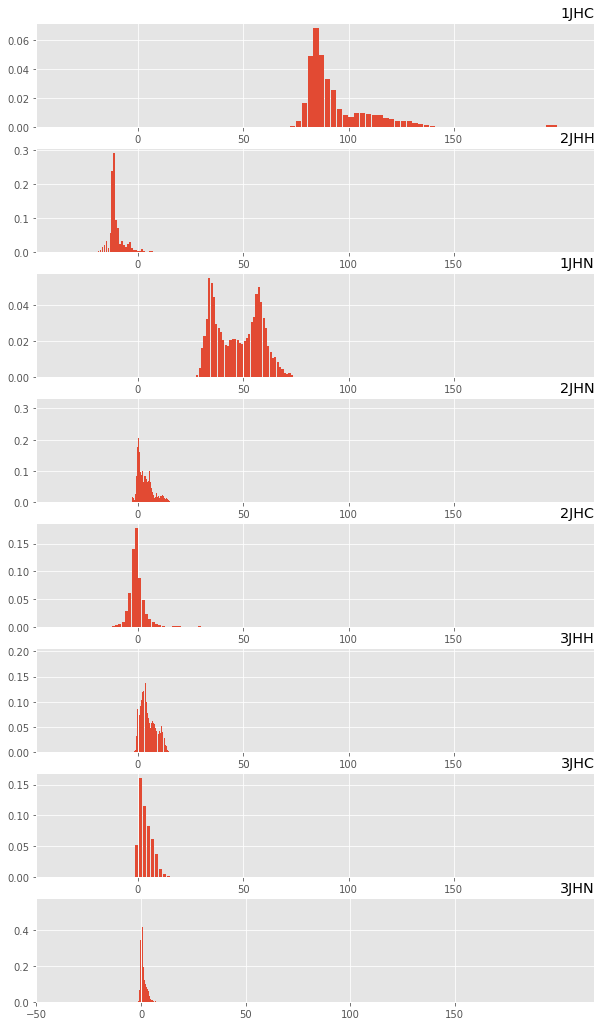

In [19]:
plt.figure(figsize=(10,18))
for T,splot in zip(TYPES, range(1,1+len(TYPES))):
    plt.subplot(len(TYPES),1,splot,sharex=plt.gca())
    plt.hist(dftrain
             ['scalar_coupling_constant']
             [dftrain['type']==T], bins=50,rwidth=0.9,density=True)
    plt.title(T,loc='right')
    plt.xticks([])
_=plt.xticks(np.arange(-50,151,50))

* 1J couplings are the strongest and most varied
* Coupling constant between atoms more than 1 bond away is usually close to 0 (with exception of 2JHH)

How lucky can we get if we draw from distribution or mean? They seem to be pretty wild, so, probably not good enough. Especially **1JHN** has two peaks

In [20]:
dftrain = pd.read_csv(in_dir+'train.csv').drop(columns=['id','molecule_name','atom_index_0','atom_index_1'])

In [21]:
# line 1 draw from normal dist, line 2 predict mean #
# uncomment whichever you need                      #
#---------------------------------------------------#

# random_pred = np.random.normal(loc=dist_table['MEAN'].loc[dftrain['type']], scale=dist_table['STDEV'].loc[dftrain['type']]*0.5,)
random_pred = dist_table['MEAN'].loc[dftrain['type']]

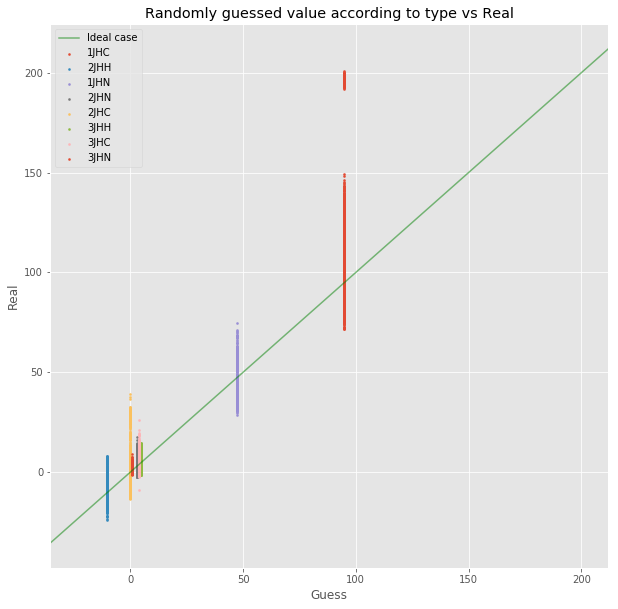

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.title('Randomly guessed value according to type vs Real')
for T in TYPES:
    bool_only_T = (dftrain['type']==T).values
    # do not plot all data (too big)
    plt.scatter(random_pred[bool_only_T][::150]
                ,dftrain['scalar_coupling_constant'][bool_only_T][::150]
                ,label=T,s=4)

plt.ylabel('Real')
plt.xlabel('Guess')

plt.xlim(plt.ylim()[0], plt.ylim()[1]) # set limits to be same
minv, maxv = plt.xlim()
straight_line, = plt.plot([minv,maxv],[minv,maxv], c='green', alpha=0.5, label='Ideal case')
_ = plt.legend()

We can see random guessing give *OK* predictions. Types that have coupling constant around 0 are more tight meaning influence is bigger (?). 

We can check the accuracy metrics of our random model, and get good baseline that more sophisticated models should aim to beat

In [23]:
def eval_model(preds, real, ts):
    score=0
    for T in TYPES:
        bool_t = ts==T
        nt = len(preds[bool_t])
        temp = np.sum(np.abs(preds[bool_t]-real[bool_t]) / nt)
        score += np.log(temp)
    return score/(len(TYPES))
eval_model(random_pred.values,dftrain['scalar_coupling_constant'].values,dftrain['type'].values)

1.2366001783502583

This is pretty bad result. We would like models that can achieve negative results. But hopefully we have achieved good insight to part of dataset. Next I will analyze the realation between xyz coordinates.

**Question of day:** is it better to feed type as categorical variable *OR* split it into 3 parts (how many bonds, atom 1, atom 2) and use that?